In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
prices_df = pd.read_csv("all_prices.csv", index_col=None).set_index("Date")
all_df = pd.read_csv("all_diff.csv", index_col=None).set_index("Date")
all_df_train = all_df.iloc[:230]
all_df_test = all_df.iloc[230:]
prices_train = prices_df.iloc[:230]
prices_test = prices_df.iloc[230:]
prices_df_train = prices_df.iloc[:230]
prices_df_test = prices_df.iloc[230:]

cc_df = all_df.iloc[:, :28]
ind_df = all_df.iloc[:, 28:]
cc_df_train = all_df_train.iloc[:, :28]
ind_df_train = all_df_train.iloc[:, 28:]
cc_df_test = all_df_test.iloc[:, :28]
ind_df_test = all_df_test.iloc[:, 28:]

ind_prices_df = prices_df.iloc[:, 28:]
ind_prices_train = ind_prices_df[:230]
ind_prices_test = ind_prices_df[230:]



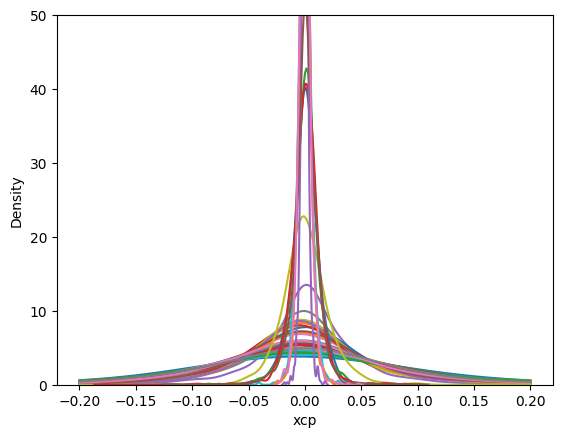

In [3]:
for col in all_df:
    ax = sns.kdeplot(all_df[col], clip=(-0.2,0.2))
    ax.set(ylim=(0,50))

In [4]:
## Constant weights
def cw_get_weights(df):
    df_length = len(df.columns)
    return [1/df_length]*df_length

def cw_rebalance_weights(weights):
    l = len(weights)
    return [sum(weights)/l]*l

In [5]:
def get_var_cvar(returns):
    returns = sorted(returns)
    percent = 0.05
    inv_percent = int(1/percent)
    position = len(returns) // inv_percent
    remainder = len(returns) % inv_percent
    var = returns[position] + (returns[position + 1] - returns[position]) * remainder / inv_percent
    cvar_returns = [z for z in returns if z <= var]
    cvar = np.mean(cvar_returns)
    return var, cvar

In [6]:
## Constant weights unrebalanced
cw_ind_weights = cw_get_weights(ind_df_test)
cw_ind_wealth = [1]
old_wealth = 1
cw_ind_ret = []

for i in range(1615):
    cw_ind_weights = np.array(cw_ind_weights) * (np.array(ind_df_test.iloc[i]) + 1)
    new_wealth = sum(cw_ind_weights)
    cw_ind_wealth.append(new_wealth)
    cw_ind_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth
    
cw_ind_sharpe = np.mean(cw_ind_ret)/np.std(cw_ind_ret)
cw_ind_var, cw_ind_cvar = get_var_cvar(cw_ind_ret)

In [7]:
## S&P100
sp100_weights = [1]
sp100_wealth = [1]
old_wealth = 1
sp100_ret = []

for i in range(1615):
    sp100_weights = np.array(sp100_weights) * (np.array(ind_df_test["S&P100"].iloc[i]) + 1)
    new_wealth = sum(sp100_weights)
    sp100_wealth.append(new_wealth)
    sp100_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

sp100_sharpe = np.mean(sp100_ret)/np.std(sp100_ret)
sp100_var, sp100_cvar = get_var_cvar(sp100_ret)


In [8]:
## Max Ret (Traditional)
mrtra_wealth = [1]
old_wealth = 1
mrtra_ret = []
mrtra_max_name = (ind_df_train+1).prod().idxmax()
mrtra_weights = [1 if col == mrtra_max_name else 0 for col in ind_df_train.columns]

for i in range(1615):
    if i % 21 == 0 and i != 0:
        mrtra_max_name = (ind_df_test.iloc[i-21:i]+1).prod().idxmax()
        mrtra_weights = [old_wealth if col == mrtra_max_name else 0 for col in ind_df_test.columns]
    mrtra_weights = np.array(mrtra_weights) * (np.array(ind_df_test.iloc[i]) + 1)
    new_wealth = sum(mrtra_weights)
    mrtra_wealth.append(new_wealth)
    mrtra_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

mrtra_sharpe = np.mean(mrtra_ret)/np.std(mrtra_ret)
mrtra_var, mrtra_cvar = get_var_cvar(mrtra_ret)

In [9]:
## Max Ret (All)
mrall_wealth = [1]
old_wealth = 1
mrall_ret = []
mrall_max_name = (all_df_train+1).prod().idxmax()
mrall_weights = [1 if col == mrall_max_name else 0 for col in all_df_train.columns]

for i in range(1615):
    if i % 21 == 0 and i != 0:
        mrall_max_name = (all_df_test.iloc[i-21:i]+1).prod().idxmax()
        mrall_weights = [old_wealth if col == mrall_max_name else 0 for col in all_df_test.columns]
    mrall_weights = np.array(mrall_weights) * (np.array(all_df_test.iloc[i]) + 1)
    new_wealth = sum(mrall_weights)
    mrall_wealth.append(new_wealth)
    mrall_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

mrall_sharpe = np.mean(mrall_ret)/np.std(mrall_ret)
mrall_var, mrall_cvar = get_var_cvar(mrall_ret)

In [10]:
from scipy.optimize import minimize
def mv_get_weights(df):
    def objective(weights):
        return np.dot(weights.T, np.dot(df.cov(), weights))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(len(df.columns)))
    initial_weights = np.ones(len(df.columns)) / len(df.columns)
    result = minimize(objective, initial_weights, method = "SLSQP", constraints = constraints, bounds = bounds)
    return result.x

In [11]:
#Min var
mv_wealth = [1]
old_wealth = 1
mv_ret = []
mv_weights = mv_get_weights(all_df_train)

for i in range(1615):
    if i % 21 == 0 and i != 0:
        mv_weights = mv_get_weights(all_df_test[i-21:i])*old_wealth
    mv_weights = np.array(mv_weights) * (np.array(all_df_test.iloc[i]) + 1)
    new_wealth = sum(mv_weights)
    mv_wealth.append(new_wealth)
    mv_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

mv_sharpe = np.mean(mv_ret)/np.std(mv_ret)
mv_var, mv_cvar = get_var_cvar(mv_ret)

In [12]:
## Max sharpe
def ms_get_weights(df):
    def objective(weights):
        p_return = np.dot(weights.T, df.mean())
        p_vol = np.sqrt(np.dot(weights.T, np.dot(df.cov(), weights)))
        neg_sharpe = - p_return / p_vol
        return neg_sharpe # aiming to max sharpe ratio by min (-ve sharpe ratio)
    
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(len(df.columns)))
    initial_weights = np.ones(len(df.columns))/len(df.columns)
    result = minimize(objective, initial_weights, method = "SLSQP", bounds = bounds, constraints = constraints)
    return result.x

In [13]:
ms_wealth = [1]
old_wealth = 1
ms_ret = []
ms_weights = ms_get_weights(all_df_train)

for i in range(1615):
    if i % 21 == 0 and i != 0:
        ms_weights = ms_get_weights(all_df_test[i-21:i])*old_wealth
    ms_weights = np.array(ms_weights) * (np.array(all_df_test.iloc[i]) + 1)
    new_wealth = sum(ms_weights)
    ms_wealth.append(new_wealth)
    ms_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

ms_sharpe = np.mean(ms_ret)/np.std(ms_ret)    
ms_var, ms_cvar = get_var_cvar(ms_ret)

In [14]:
## Equal risk

def er_get_weights(df):
    sd_list = 1/np.array(df.std())
    sd_total = sum(sd_list)
    return sd_list/sd_total

In [15]:
er_wealth = [1]
old_wealth = 1
er_ret = []
er_weights = er_get_weights(all_df_train)

for i in range(1615):
    if i % 21 == 0 and i != 0:
        er_weights = er_get_weights(all_df_test[i-21:i])*old_wealth
    er_weights = np.array(er_weights) * (np.array(all_df_test.iloc[i]) + 1)
    new_wealth = sum(er_weights)
    er_wealth.append(new_wealth)
    er_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

er_sharpe = np.mean(er_ret)/np.std(er_ret)
er_var, er_cvar = get_var_cvar(er_ret)

In [16]:
# https://github.com/shilewenuw/deep-learning-portfolio-optimization/blob/main/Model.py
# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from keras.layers import LSTM, Flatten, Dense
from keras.models import Sequential
import keras.backend as K

import pandas as pd

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

2024-01-23 16:23:46.841830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
dltra_wealth = [1]
old_wealth = 1
dltra_ret = []
model = Model()
dltra_weights = model.get_allocations(ind_prices_train)

for i in range(1615):
    if i % 21 == 0 and i != 0:
        model = Model()
        dltra_weights = model.get_allocations(ind_prices_test[i-21:i])*old_wealth
    dltra_weights = np.array(dltra_weights) * (np.array(ind_df_test.iloc[i]) + 1)
    new_wealth = sum(dltra_weights)
    dltra_wealth.append(new_wealth)
    dltra_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

dltra_sharpe = np.mean(dltra_ret)/np.std(dltra_ret)  
dltra_var, dltra_cvar = get_var_cvar(dltra_ret)



Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0349
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: -0.0360
Epoch 3/20
1/1 [==============================] - 0s 38ms/step - loss: -0.0364
Epoch 4/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0369
Epoch 5/20
1/1 [==============================] - 0s 38ms/step - loss: -0.0373
Epoch 6/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0377
Epoch 7/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0381
Epoch 8/20
1/1 [==============================] - 0s 37ms/step - loss: -0.0385
Epoch 9/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0389
Epoch 10/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0392
Epoch 11/20
1/1 [==============================] - 0s 39ms/step - loss: -0.0396
Epoch 12/20
1/1 [==============================] - 0s 38ms/step - loss: -0.0399
Epoch 13/20
1/1 [==============================] - 

In [18]:
dlall_wealth = [1]
old_wealth = 1
dlall_ret = []
model = Model()
dlall_weights = model.get_allocations(prices_train)
dlall_weights_list = [dlall_weights]

for i in range(1615):
    if i % 21 == 0 and i != 0:
        dlall_weights = model.get_allocations(prices_test[i-21:i])*old_wealth
        dlall_weights_list.append(dlall_weights/old_wealth)
    dlall_weights = np.array(dlall_weights) * (np.array(all_df_test.iloc[i]) + 1)
    new_wealth = sum(dlall_weights)
    dlall_wealth.append(new_wealth)
    dlall_ret.append((new_wealth - old_wealth)/old_wealth)
    old_wealth = new_wealth

dlall_sharpe = np.mean(dlall_ret)/np.std(dlall_ret)  
dlall_var, dlall_cvar = get_var_cvar(dlall_ret)



Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0383
Epoch 2/20
1/1 [==============================] - 0s 37ms/step - loss: -0.0391
Epoch 3/20
1/1 [==============================] - 0s 36ms/step - loss: -0.0399
Epoch 4/20
1/1 [==============================] - 0s 35ms/step - loss: -0.0408
Epoch 5/20
1/1 [==============================] - 0s 35ms/step - loss: -0.0416
Epoch 6/20
1/1 [==============================] - 0s 35ms/step - loss: -0.0424
Epoch 7/20
1/1 [==============================] - 0s 35ms/step - loss: -0.0432
Epoch 8/20
1/1 [==============================] - 0s 37ms/step - loss: -0.0440
Epoch 9/20
1/1 [==============================] - 0s 36ms/step - loss: -0.0448
Epoch 10/20
1/1 [==============================] - 0s 36ms/step - loss: -0.0455
Epoch 11/20
1/1 [==============================] - 0s 35ms/step - loss: -0.0463
Epoch 12/20
1/1 [==============================] - 0s 34ms/step - loss: -0.0470
Epoch 13/20
1/1 [==============================] - 

In [19]:
for i in dlall_weights_list:
    print(i)

[0.01600212 0.07646728 0.0086284  0.01387742 0.02166124 0.0136997
 0.03930967 0.07246828 0.01773101 0.0130229  0.02677411 0.02592459
 0.01165882 0.01358075 0.08771893 0.02578027 0.03116035 0.00993181
 0.0281805  0.01028013 0.03540779 0.03321518 0.01992158 0.04156834
 0.0283595  0.00849844 0.04913361 0.01446701 0.00870565 0.02199365
 0.05216992 0.01703807 0.04071657 0.01476853 0.00753547 0.02082145
 0.02182098]
[0.01627622 0.11839119 0.00737349 0.01310908 0.01643062 0.01019949
 0.03162416 0.0562383  0.02617983 0.01155403 0.01931977 0.01986071
 0.00846815 0.01115869 0.13703556 0.01901854 0.0391042  0.00725383
 0.03084886 0.00866062 0.02598084 0.02414663 0.01584841 0.06529535
 0.04449912 0.00615996 0.04843453 0.01055122 0.00635412 0.01624204
 0.03777149 0.0131103  0.02947669 0.01086479 0.00564018 0.01511516
 0.01640384]
[0.01494631 0.16439456 0.00506222 0.00881812 0.01057521 0.00639742
 0.02012593 0.03625111 0.03481082 0.00687067 0.01234048 0.01321542
 0.00555069 0.00721382 0.19404706 0.0

In [20]:
all_df_train.describe()

,xcp,dgb,emc2,sys,btc,ftc,dmd,ltc,doge,qrk,...,via,Treasury,GBPUSD,N225,EURUSD,STOXX50,VNQ,CNYUSD,S&P100,JPYUSD
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,...,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,-0.003364,0.013731,-0.001164,0.006098,0.002939,0.003020,0.008678,0.005389,0.001073,0.003799,...,-0.004376,0.000873,-0.000119,0.000482,-0.000353,0.000480,0.000116,-0.000190,0.000195,0.000011
std,0.094389,0.154261,0.089535,0.131434,0.044292,0.136426,0.117741,0.081035,0.052666,0.118700,...,0.106432,0.020037,0.005483,0.013724,0.008295,0.015176,0.011174,0.001839,0.010266,0.005272
min,-0.296267,-0.368436,-0.259006,-0.377910,-0.235304,-0.379069,-0.327674,-0.421440,-0.216531,-0.337155,...,-0.316606,-0.048193,-0.020362,-0.046057,-0.023535,-0.053544,-0.046815,-0.018240,-0.039294,-0.013471
25%,-0.062367,-0.045017,-0.057775,-0.063850,-0.012722,-0.053699,-0.031506,-0.018341,-0.022357,-0.058377,...,-0.064498,-0.011825,-0.003045,-0.006379,-0.004688,-0.008116,-0.005855,-0.000604,-0.005172,-0.003085
50%,-0.006073,-0.009387,-0.004945,-0.008723,0.002535,-0.010177,-0.000926,0.000411,-0.002141,-0.009226,...,-0.004884,-0.000857,-0.000328,0.001317,-0.000466,0.001219,0.000404,0.000000,-0.000113,-0.000301
75%,0.050355,0.039805,0.042390,0.051159,0.019587,0.034365,0.050265,0.017359,0.018956,0.037680,...,0.041288,0.012379,0.003001,0.008177,0.004575,0.009294,0.007897,0.000391,0.006307,0.002827
max,0.344161,1.500266,0.417374,0.886184,0.223110,0.758555,1.206447,0.454121,0.230764,0.695100,...,0.467094,0.057792,0.014552,0.077089,0.028545,0.047056,0.029714,0.006118,0.042839,0.023981


In [21]:
wealth_d = {"Indices equal": cw_ind_wealth, "S&P100": sp100_wealth, "MaxRetTra": mrtra_wealth, "MaxRetAll": mrall_wealth, "MinVar": mv_wealth, "MaxSharpe": ms_wealth, "EqualRisk": er_wealth, "DeepLearningAll": dlall_wealth, "DeepLearningTra": dltra_wealth}
wealth_df = pd.DataFrame(data=wealth_d)

ret_d = {"Indices equal": cw_ind_ret, "S&P100": sp100_ret, "MaxRetTra": mrtra_ret, "MaxRetAll": mrall_ret, "MinVar": mv_ret, "MaxSharpe": ms_ret, "EqualRisk": er_ret, "DeepLearningAll": dlall_ret, "DeepLearningTra": dltra_ret}
ret_df = pd.DataFrame(data=ret_d)

In [66]:
import plotly.graph_objects as go

In [104]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))

fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Benchmark", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [105]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetAll"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Max return all", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [107]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MinVar"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Minimum Variance", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [108]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxSharpe"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Max sharpe ratio", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [109]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["EqualRisk"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Equal Risk", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [111]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["DeepLearningAll"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Deep learning all", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [113]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=wealth_df["Indices equal"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["S&P100"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["MaxRetTra"], mode = "lines"))
fig.add_trace(go.Scatter(y=wealth_df["DeepLearningTra"], mode = "lines"))


fig.update_xaxes(tickfont = dict(size=20))

fig.update_yaxes(title_text = "Wealth",
                title_font = dict(size=20),
                tickfont = dict(size=20)
                 )

fig.update_layout(title=dict(text="Deep learning traditional", x=0.5, y=0.85, font=dict(size=20)),
                  showlegend=False,
                  width=800, height=400,
                  )

fig.show()

In [29]:
ret_d = {"Indices equal": cw_ind_ret, "S&P100": sp100_ret, "MaxRetTra": mrtra_ret, "MaxRetAll": mrall_ret, "MinVar": mv_ret, "MaxSharpe": ms_ret, "EqualRisk": er_ret, "DeepLearningAll": dlall_ret,"DeepLearningTra": dltra_ret}
ret_df = pd.DataFrame(ret_d)
ret_df.describe()

,Indices equal,S&P100,MaxRetTra,MaxRetAll,MinVar,MaxSharpe,EqualRisk,DeepLearningAll,DeepLearningTra
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,0.000124,0.000464,0.000294,0.007428,0.001185,0.001010,0.001203,0.007478,0.000207
std,0.006057,0.012664,0.015113,0.168455,0.015123,0.014714,0.015611,0.089982,0.006807
min,-0.061511,-0.115689,-0.101303,-0.565209,-0.181920,-0.137078,-0.082425,-0.465063,-0.070833
25%,-0.002262,-0.003874,-0.005705,-0.047034,-0.004327,-0.003874,-0.004893,-0.026714,-0.002448
50%,0.000333,0.000598,0.000000,-0.003314,0.000590,0.000440,0.000905,0.001876,0.000406
75%,0.003042,0.005951,0.006631,0.037654,0.005583,0.005335,0.006894,0.031543,0.003239
max,0.040503,0.101270,0.096197,3.389011,0.145201,0.171790,0.221464,1.499116,0.041552


In [30]:
var_names = ["Indices equal", "S&P100", "MaxRetTra", "MaxRetAll", "MinVar", "MaxSharpe", "EqualRisk", "DeepLearningAll", "DeepLearningTra"]
var_values = [cw_ind_var, sp100_var, mrtra_var, mrall_var, mv_var, ms_var,er_var, dlall_var, dltra_var]
var_df = pd.DataFrame({"Method": var_names, "VaR": var_values})

var_df

,Method,VaR
0,Indices equal,-0.008798
1,S&P100,-0.019001
2,MaxRetTra,-0.022280
3,MaxRetAll,-0.161469
4,MinVar,-0.015580
5,MaxSharpe,-0.015833
6,EqualRisk,-0.019419
7,DeepLearningAll,-0.090456
8,DeepLearningTra,-0.009697


In [31]:
cvar_names = ["Indices equal", "S&P100", "MaxRetTra", "MaxRetAll", "MinVar", "MaxSharpe", "EqualRisk", "DeepLearningAll", "DeepLearningTra"]
cvar_values = [cw_ind_cvar, sp100_cvar, mrtra_cvar, mrall_cvar, mv_cvar, ms_cvar, er_cvar, dlall_cvar, dltra_cvar]
cvar_df = pd.DataFrame({"Method": cvar_names, "CVaR": cvar_values})

cvar_df

,Method,CVaR
0,Indices equal,-0.015176
1,S&P100,-0.031647
2,MaxRetTra,-0.035321
3,MaxRetAll,-0.256871
4,MinVar,-0.030543
5,MaxSharpe,-0.032257
6,EqualRisk,-0.034122
7,DeepLearningAll,-0.150063
8,DeepLearningTra,-0.016305


In [32]:
sharpe_names = ["Indices equal", "S&P100", "MaxRetTra", "MaxRetAll", "MinVar", "MaxSharpe", "EqualRisk", "DeepLearningAll", "DeepLearningTra"]
sharpe_values = [cw_ind_cvar, sp100_cvar, mrtra_cvar, mrall_cvar, mv_cvar, ms_cvar, er_cvar, dlall_cvar, dltra_cvar]
sharpe_df = pd.DataFrame({"Method": sharpe_names, "Sharpe Ratio": sharpe_values})

sharpe_df

,Method,Sharpe Ratio
0,Indices equal,-0.015176
1,S&P100,-0.031647
2,MaxRetTra,-0.035321
3,MaxRetAll,-0.256871
4,MinVar,-0.030543
5,MaxSharpe,-0.032257
6,EqualRisk,-0.034122
7,DeepLearningAll,-0.150063
8,DeepLearningTra,-0.016305


In [33]:
var_cvar_sharpe = pd.DataFrame({"Method": var_names, "VaR": var_values, "CVaR": cvar_values, "Sharpe ratio": sharpe_values})
var_cvar_sharpe

,Method,VaR,CVaR,Sharpe ratio
0,Indices equal,-0.008798,-0.015176,-0.015176
1,S&P100,-0.019001,-0.031647,-0.031647
2,MaxRetTra,-0.022280,-0.035321,-0.035321
3,MaxRetAll,-0.161469,-0.256871,-0.256871
4,MinVar,-0.015580,-0.030543,-0.030543
5,MaxSharpe,-0.015833,-0.032257,-0.032257
6,EqualRisk,-0.019419,-0.034122,-0.034122
7,DeepLearningAll,-0.090456,-0.150063,-0.150063
8,DeepLearningTra,-0.009697,-0.016305,-0.016305


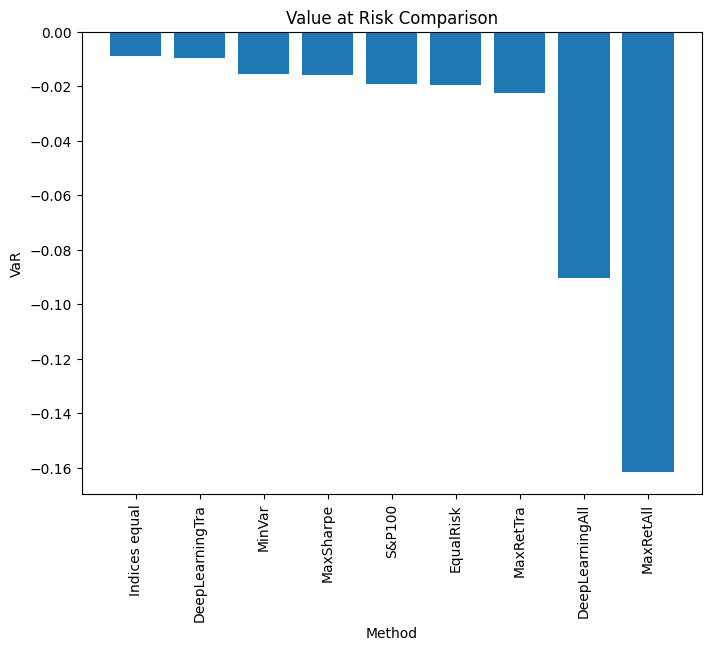

In [44]:
var_cvar_sharpe = var_cvar_sharpe.sort_values(by = "VaR", ascending = False)
plt.figure(figsize=(8, 6))
plt.bar(var_cvar_sharpe["Method"], var_cvar_sharpe["VaR"])
plt.title("Value at Risk Comparison")
plt.xlabel("Method")
plt.ylabel("VaR")
plt.xticks(rotation=90)
plt.show()

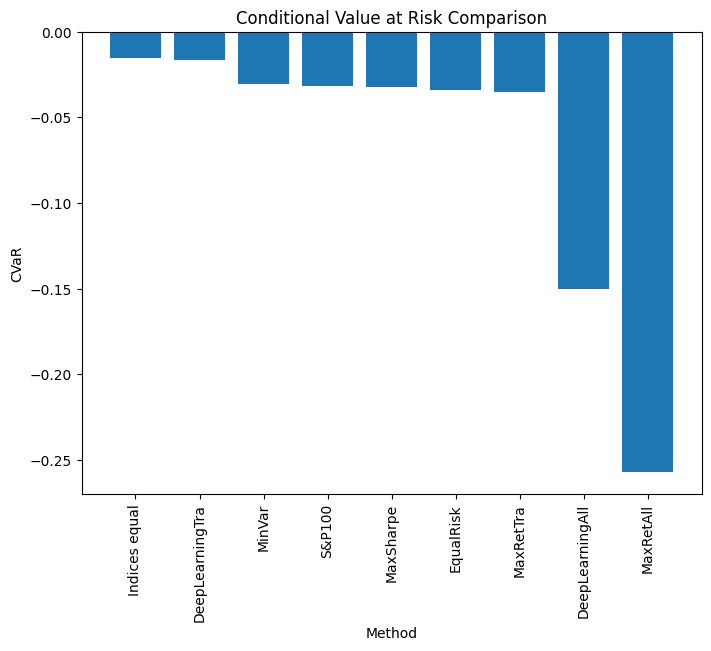

In [45]:
var_cvar_sharpe = var_cvar_sharpe.sort_values(by = "CVaR", ascending = False)
plt.figure(figsize=(8, 6))
plt.bar(var_cvar_sharpe["Method"], var_cvar_sharpe["CVaR"])
plt.title("Conditional Value at Risk Comparison")
plt.xlabel("Method")
plt.ylabel("CVaR")
plt.xticks(rotation=90)
plt.show()

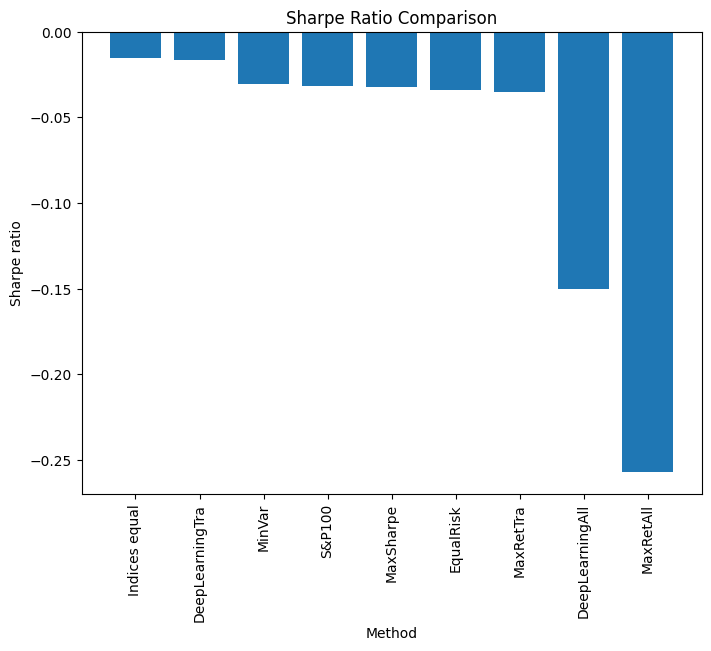

In [46]:
var_cvar_sharpe = var_cvar_sharpe.sort_values(by = "Sharpe ratio", ascending = False)
plt.figure(figsize=(8, 6))
plt.bar(var_cvar_sharpe["Method"], var_cvar_sharpe["Sharpe ratio"])
plt.title("Sharpe Ratio Comparison")
plt.xlabel("Method")
plt.ylabel("Sharpe ratio")
plt.xticks(rotation=90)
plt.show()

In [34]:
all_df_test.describe()

,xcp,dgb,emc2,sys,btc,ftc,dmd,ltc,doge,qrk,...,via,Treasury,GBPUSD,N225,EURUSD,STOXX50,VNQ,CNYUSD,S&P100,JPYUSD
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,...,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,0.020441,0.008950,0.018371,0.008818,0.003448,0.008424,0.005189,0.004356,0.009390,0.027449,...,0.010460,0.000491,-0.000106,0.000280,-0.000003,0.000173,0.000293,-0.000041,0.000464,-0.000044
std,0.337596,0.129154,0.267701,0.109582,0.048528,0.145970,0.091723,0.073543,0.134751,0.316410,...,0.185976,0.025484,0.006616,0.013016,0.004898,0.012937,0.014474,0.002975,0.012664,0.005846
min,-0.916016,-0.436885,-0.907227,-0.466705,-0.351903,-0.695753,-0.582209,-0.375860,-0.481202,-0.828078,...,-0.811558,-0.228807,-0.076039,-0.079216,-0.025438,-0.124014,-0.177277,-0.015676,-0.115689,-0.023346
25%,-0.047049,-0.042796,-0.046425,-0.041848,-0.017565,-0.048229,-0.035567,-0.025671,-0.028250,-0.036970,...,-0.047883,-0.011298,-0.003589,-0.005959,-0.002979,-0.005354,-0.005566,-0.001397,-0.003874,-0.003190
50%,-0.003763,-0.004368,-0.002547,0.000594,0.002535,-0.004879,-0.000629,-0.000155,-0.002771,-0.001327,...,0.000145,0.000000,-0.000136,0.000434,-0.000059,0.000634,0.000707,0.000000,0.000598,-0.000110
75%,0.043741,0.037497,0.045129,0.046586,0.024462,0.044573,0.037812,0.027871,0.024974,0.030978,...,0.044303,0.011650,0.003357,0.006850,0.002869,0.006196,0.006982,0.001334,0.005951,0.003036
max,9.948822,2.323395,6.736488,1.016760,0.332556,2.329653,1.010928,0.788372,3.389011,4.521861,...,5.701030,0.300961,0.030772,0.080381,0.018795,0.092362,0.089966,0.018391,0.101270,0.047619


In [35]:
ret_df.describe()

,Indices equal,S&P100,MaxRetTra,MaxRetAll,MinVar,MaxSharpe,EqualRisk,DeepLearningAll,DeepLearningTra
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,0.000124,0.000464,0.000294,0.007428,0.001185,0.001010,0.001203,0.007478,0.000207
std,0.006057,0.012664,0.015113,0.168455,0.015123,0.014714,0.015611,0.089982,0.006807
min,-0.061511,-0.115689,-0.101303,-0.565209,-0.181920,-0.137078,-0.082425,-0.465063,-0.070833
25%,-0.002262,-0.003874,-0.005705,-0.047034,-0.004327,-0.003874,-0.004893,-0.026714,-0.002448
50%,0.000333,0.000598,0.000000,-0.003314,0.000590,0.000440,0.000905,0.001876,0.000406
75%,0.003042,0.005951,0.006631,0.037654,0.005583,0.005335,0.006894,0.031543,0.003239
max,0.040503,0.101270,0.096197,3.389011,0.145201,0.171790,0.221464,1.499116,0.041552
